In [6]:
"""
@author Dakota Rawlings
@email dakota@mrl.ucsb.edu

This script performs some basic exploratory data analysis on a NDBC dataset

This includes lag correlation analysis, partial autocorelation plots, periodogram analysis, seosonality plots, and general summary plots

"""

import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import pandas as pd
import plotting_functions
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.linear_model import LinearRegression



## Importing and formatting the data set

In [7]:
#little function for outputing the number of missing values for each column
def get_nan_count(df):
    """Outputs the total number of null values in each column

    Args:
            df (dataframe): Any dataframe
    """
    
    missing_values_count = df.isnull().sum()
    print(missing_values_count)

In [8]:
#Format a dataframe after impoting from SQL
def format_df(df_in):
    """Function for formatting a dataframe from the database file with model training NDBC data

    Args:
            df_in (dataframe): Dataframe that has been uploaded from NDBC SQL database

    Returns:
            dataframe: formatted dataframe
    """
    
    #Copy the df, convert the datetime column to datetime object, set the datetime col as the index
    df=df_in.copy(deep=True)
    df["datetime"] = pd.to_datetime(df["datetime"])
    df=df.set_index('datetime')
    df["date"] = pd.to_datetime(df["date"])
    return df

In [10]:
#Query a list of all the tables in the database
con = sqlite3.connect(r"NDBC_model_building_database.db")
cursor = con.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

[('NDBC_historical_raw_data',), ('NDBC_historical_raw_data_St#{STATIONNUMBER}',), ('NDBC_historical_raw_data_St{STATIONNUMBER}',), ('NDBC_historical_raw_data_St46054',), ('NDBC_historical_data_for_training',), ('NDBC_historical_cleaned_data',)]


In [11]:
#Query cleaned data from DB
conn = sqlite3.connect(r"NDBC_model_building_database.db")
df_cleaned = pd.read_sql_query("SELECT * FROM NDBC_historical_cleaned_data", conn, index_col=None)

In [12]:
#call our data formating function and initialize new df for our engineered data
df_engineered=format_df(df_cleaned)

## Preliminary Feature Engineering

In [13]:
#convert pressure from bars to atm
df_engineered['PRES']=df_engineered['PRES'].apply(lambda x: x/1013.25 )

In [14]:
get_nan_count(df_engineered)


WDIR    0
WSPD    0
GST     0
PRES    0
ATMP    0
WTMP    0
date    0
dtype: int64


In [15]:
df_engineered.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 93812 entries, 2003-06-06 14:00:00 to 2014-02-17 09:00:00
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   WDIR    93812 non-null  float64       
 1   WSPD    93812 non-null  float64       
 2   GST     93812 non-null  float64       
 3   PRES    93812 non-null  float64       
 4   ATMP    93812 non-null  float64       
 5   WTMP    93812 non-null  float64       
 6   date    93812 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(6)
memory usage: 5.7 MB


array([<AxesSubplot:title={'center':'Time Plot of ATMP'}, xlabel='date', ylabel='ATMP'>,
       <AxesSubplot:>, <AxesSubplot:>], dtype=object)

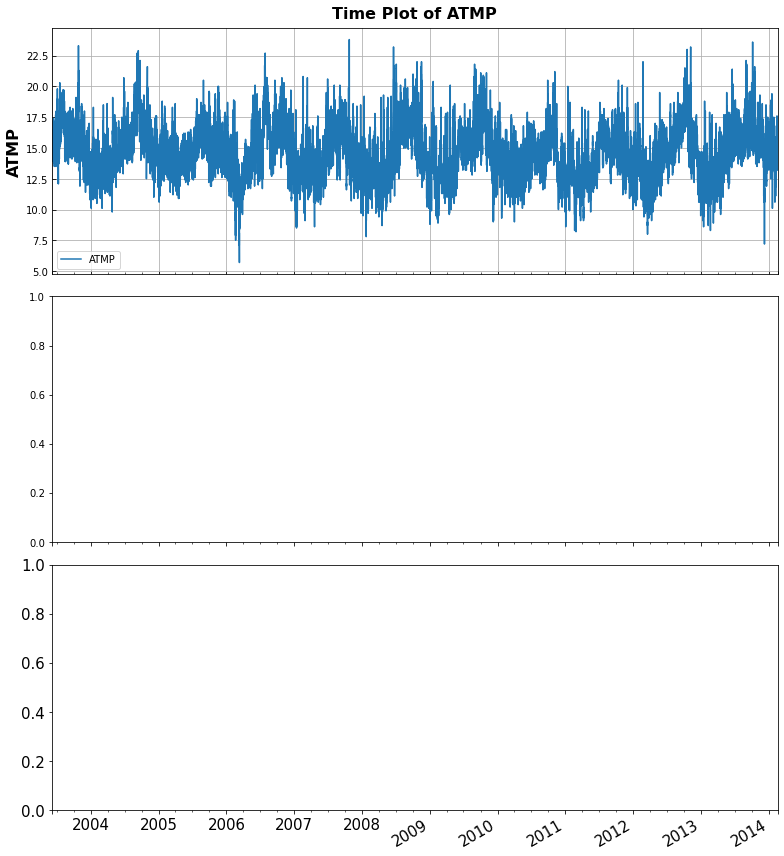

In [17]:
plotting_functions.timeseries_plot_grid(df_engineered,'date', ['ATMP','WTMP','PRES'])

In [18]:
#Resample our data to daily frequency. Here we choose the maximum value per day
df_engineered= df_engineered.resample("D").max()
#create a column with the date time for reference
df_engineered['date']=df_engineered.index

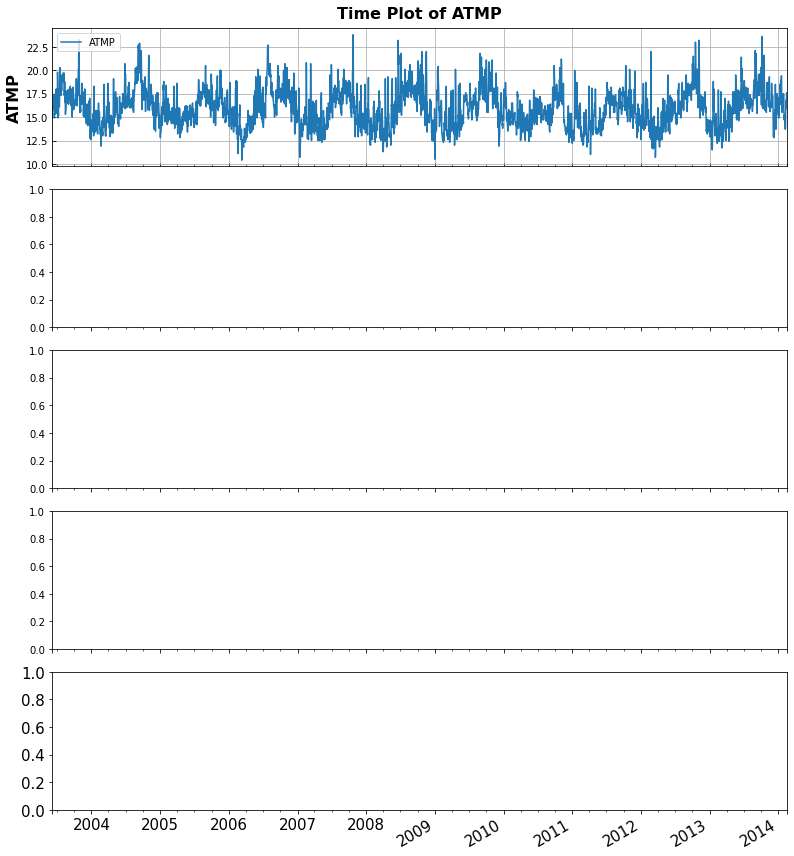

In [19]:
fig=plotting_functions.timeseries_plot_grid(df_engineered,'date', ['ATMP','WTMP','PRES', 'WSPD','GST'])

In [20]:
df_engineered.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3910 entries, 2003-06-06 to 2014-02-17
Freq: D
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   WDIR    3910 non-null   float64       
 1   WSPD    3910 non-null   float64       
 2   GST     3910 non-null   float64       
 3   PRES    3910 non-null   float64       
 4   ATMP    3910 non-null   float64       
 5   WTMP    3910 non-null   float64       
 6   date    3910 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(6)
memory usage: 244.4 KB


In [21]:
#add a timestep feature to the dataframe
df_engineered['timestep']=np.arange(len(df_engineered.index))

## EDA - Basic Summary Data

<AxesSubplot:title={'center':'Time Plot of ATMP'}, xlabel='date', ylabel='ATMP'>

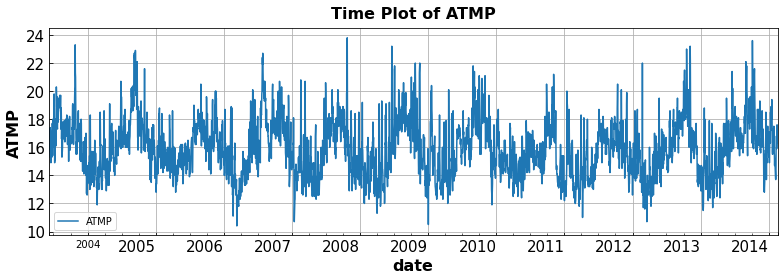

In [26]:
#Plot the ATMP data
plotting_functions.timeseries_plot(df_engineered,'date', ydata='ATMP', ax=ax)


## EDA - Timestep features and seasonality

In [15]:
#define function for making lag plots
def lag_plots(num_lags, df_in, target_column, lag_column='', num_graph_rows=2):
    """Function for making lag plots between two specified variables for  spefific number of lag steps

    Args:
            num_lags (int): the number of lag steps to plot
            df_in (dataframe): the pandas dataframe of interest
            target_column (str): the column for the y axis (generally our target)
            lag_column (str): The column that we will lag and plot the target against (default '', in which case the target will be lagged)
            num_graph_rows (int): The number of rows of sublots (default 2)

    """

    #decide rough sublot dimensions
    num_graph_cols=math.ceil(float(num_lags)/num_graph_rows)
    #copy dataframe
    df=df_in.copy(deep=True)
    #initialize sublot axes
    fig, ax = plt.subplots(num_graph_rows, num_graph_cols)
    #Set figure and axes parameters
    plt.rc("figure", figsize=(5*num_graph_cols,5*num_graph_rows),titlesize=12,titleweight='bold', autolayout=True)
    plt.rc("axes", labelweight="bold", labelsize='Large', titleweight="bold", titlesize=16, titlepad=10)
    #set default lag column as the target column
    if len(lag_column)==0:
        lag_column=target_column
    #loop over the specified range of lags 
    for i in range(num_lags):
        #start our number of lags at 1
        lag=i+1
        #make a new column in our df shifted by the number of lags
        new_lag_column=f'{lag_column}_lag_{lag}'
        df[new_lag_column]=df[lag_column].shift(lag)
        
        #Set our X variable as our lagged column
        X=df.loc[:,[new_lag_column]]
        #drop nan values
        X.dropna(inplace=True)
        #set our y variable as our target column
        y=df_engineered.loc[:,target_column]
        #allign y and X so that we drop rows that are not shared
        y,X=y.align(X, join='inner')
        #Fit a simple linear regressison to our y and x
        model=LinearRegression()
        model.fit(X,y)
        # create a series with our fit
        y_pred=pd.Series(model.predict(X), index=X.index)
        #iterate the row and column number based on the index
        row=i//num_graph_cols
        col=i-(num_graph_cols*row)
        #Plot the target value vs. the lag value and plot the fit
        ax[row,col].plot(X[f'{lag_column}_lag_{lag}'], y, '.', color='0.25')
        ax[row,col].plot(X[f'{lag_column}_lag_{lag}'], y_pred, color='red')
        # ax[row,col].set_aspect('equal')
        ax[row,col].set_ylabel(f'{target_column}', fontsize=12)
        ax[row,col].set_xlabel(f'{lag_column}_lag_{lag}', fontsize=12)
        ax[row,col].set_title(f'Lag {lag}')

  




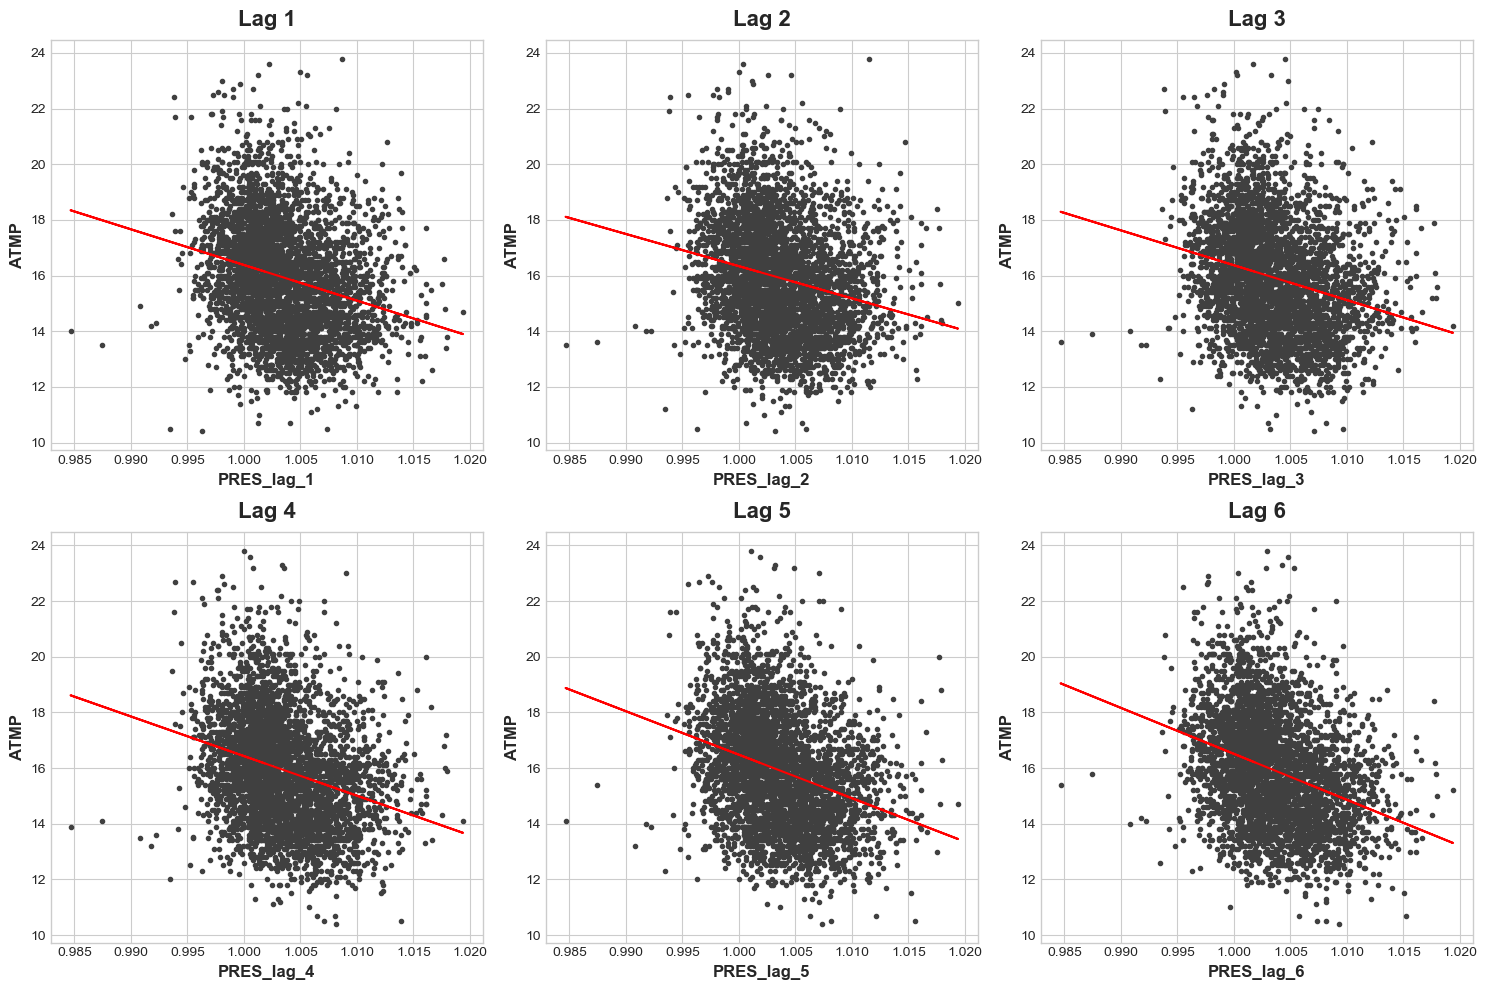

In [23]:
#use our lag plot function to explore what lag featureres are useful
lag_plots(6, df_engineered, 'ATMP', lag_column='PRES')

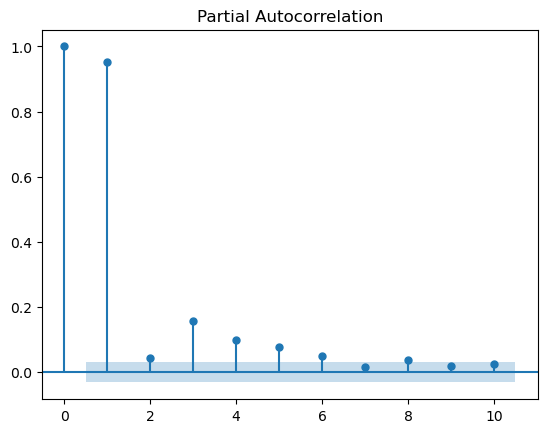

In [17]:
#plot a partial autocorrelation plot for our feature to help decide which lags contain useful forecasting information
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
fig=plot_pacf(df_engineered['WTMP'], lags=10)

In [27]:
# Seasonal plot and periodogram functions adapted from https://www.kaggle.com/code/ryanholbrook/seasonality
def seasonal_plot(X, y, period, freq, ax=None):
    """Function for making seasonal plot with a column of timeseries data

    Args:
            X (dataframe): dataframe with timeseries index data (including column for period and frequency)
            y (str): column with target value
            period (str): column with the period data
            freq (str): timeseries column
            ax (obj): matplot lib axis object

    Returns:
           obj: matplotlib axis object
    """

    #Set plot style
    plt.style.use("seaborn-whitegrid")
    plt.rc("figure", autolayout=True, figsize=(11, 5))
    #if an axis is not provided, create an axis object
    if ax is None:
        fig, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique())
    #Plot lineplots over the specified period
    ax = sns.lineplot(x=freq, y=y, hue=period, data=X, ci=False, ax=ax, palette=palette,legend=False)
    #Add title and data labels
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(name, xy=(1, y_), xytext=(6, 0), color=line.get_color(), xycoords=ax.get_yaxis_transform(), textcoords="offset points", size=14, va="center")
    return ax

#function for constructing a periodogram
def plot_periodogram(ts, detrend='linear', ax=None):
    """Function for making seasonal plot with a column of timeseries data

    Args:
            ts (dataframe): dataframe with timeseries data
            detrend (str): specify how to detrend the column
            ax (obj): matplot lib axis object

    Returns:
           obj: matplotlib axis object
    """
    #plot formatting
    plt.style.use("seaborn-whitegrid")
    plt.rc("figure", autolayout=True, figsize=(11, 5))
    #import periodogram function from scipy
    from scipy.signal import periodogram
    #Set the sampling frequency
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    #Get frequency range and spectral density as a function of the frequency
    freqencies, spectrum = periodogram(ts, fs=fs, detrend=detrend, window="boxcar", scaling='spectrum')
    #create an axis object
    if ax is None:
        fig, ax = plt.subplots()
    #create a step plot witht the frequency and spectral density data
    ax.step(freqencies, spectrum, color="purple")
    #format x axis with ticks at common time intervals
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels( [ "Annual (1)", "Semiannual (2)", "Quarterly (4)", "Bimonthly (6)", "Monthly (12)", "Biweekly (26)", "Weekly (52)", "Semiweekly (104)"],rotation=30)
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax


<AxesSubplot:title={'center':'Seasonal Plot (year/dayofyear)'}, xlabel='dayofyear', ylabel='ATMP'>

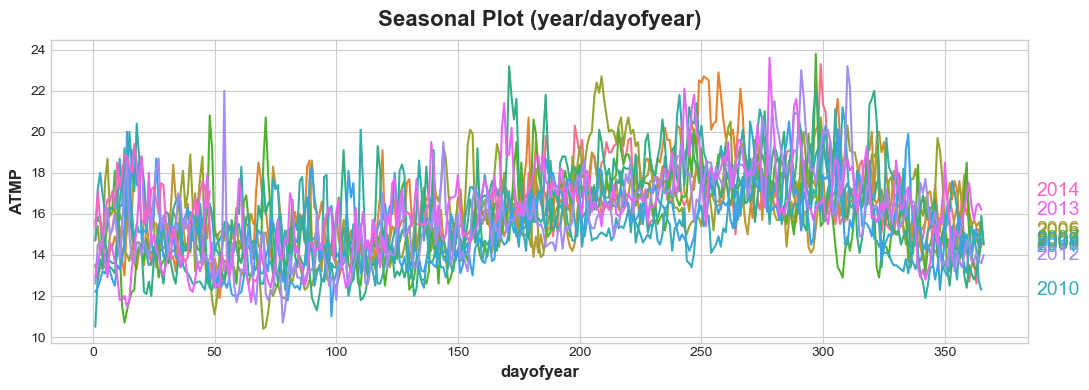

In [24]:
#use our seosonal plot function to explore seasonality of data with annual period
X = df_engineered.copy()
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year
fig, ax = plt.subplots( figsize=(11, 4))
seasonal_plot(X, y="ATMP", period="year", freq="dayofyear", ax=ax)


<ipython-input-28-a59f06d61923>:2: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  plot_periodogram(df_engineered['ATMP'])


<AxesSubplot:title={'center':'Periodogram for {ts.name}'}, ylabel='Variance'>

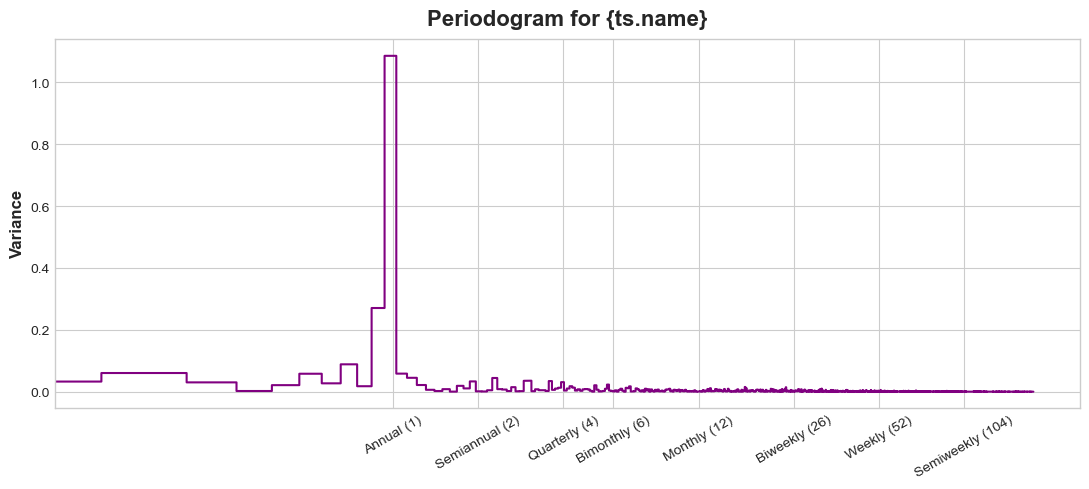

In [28]:
#use the periodogram function above to plot a periodogram with specified data
plot_periodogram(df_engineered['ATMP'])